# Packages

In [7]:
from numpy import *
from prody import *
from matplotlib.pyplot import *
from scipy.stats import hypergeom
import os
ion()

# Functions

In [8]:
# -*- coding: utf-8 -*-
"""This module defines functions for Dali searching Protein Data Bank."""

import re
import numpy as np
from prody.atomic import Atomic, AtomGroup, AtomMap
from prody.proteins.pdbfile import _getPDBid
from prody.measure import getRMSD, getTransformation
from prody.utilities import checkCoords, checkWeights, createStringIO
from prody import LOGGER, PY3K
from prody import parsePDB, writePDBStream
# if PY3K:
    # import urllib.parse as urllib
    # import urllib.request as urllib2
# else:
    # import urllib
    # import urllib2
from prody.ensemble import Ensemble
from prody.ensemble import PDBEnsemble
import os

__all__ = ['DaliRecord', 'searchDali', 
           'daliFilterMultimer', 'daliFilterMultimers']

def searchDal(pdb, chain=None, subset='fullPDB', daliURL=None, **kwargs):
    """Search Dali server with input of PDB ID (or local PDB file) and chain ID.
    Dali server: http://ekhidna2.biocenter.helsinki.fi/dali/
    
    :arg pdb: PDB code or local PDB file for the protein to be searched

    :arg chain: chain identifier (only one chain can be assigned for PDB)
    :type chain: str

    :arg subset: fullPDB, PDB25, PDB50, PDB90
    :type subset: str
    """
    
    import requests
    
    LOGGER.timeit('_dali')
    # timeout = 120
    timeout = kwargs.pop('timeout', 120)
    
    if daliURL is None:
        daliURL = "http://ekhidna2.biocenter.helsinki.fi/cgi-bin/sans/dump.cgi"
    
    if isinstance(pdb, Atomic):
        atoms = pdb
        chain_set = set(atoms.getChids())
        if chain and not chain in chain_set:
            raise ValueError('input structure (%s) does not have chain %s'%(atoms.getTitle(), chain))
        
        if len(chain_set) > 1:
            if not chain:
                raise TypeError('the structure (%s) contains more than one chain, therefore a chain identifier '
                                'needs to be specified'%pdb.getTitle())
            atoms = atoms.select('chain '+chain)
        else:
            chain = chain_set.pop()
            
        stream = createStringIO()
        writePDBStream(stream, atoms)
        data = stream.getvalue()
        stream.close()
        files = {"file1" : data}

        pdbId = atoms.getTitle()
        pdb_chain = ''
        dali_title = 'Title_'+pdbId+chain
    elif isinstance(pdb, str):
        if os.path.isfile(pdb):
            atoms = parsePDB(pdb)
            chain_set = set(atoms.getChids())
            # pdbId = "s001"
            filename = os.path.basename(pdb)
            filename, ext = os.path.splitext(filename)
            if ext.lower() == '.gz':
                filename2, ext2 = os.path.splitext(filename)
                if ext2.lower() == '.pdb':
                    filename = filename2
            pdbId = filename
            if chain and not chain in chain_set:
                raise ValueError('input PDB file does not have chain ' + chain)
            
            if len(chain_set) > 1:
                if not chain:
                    raise TypeError('PDB file (%s) contains more than one chain, therefore a chain identifier '
                                    'needs to be specified'%pdb)
                atoms = atoms.select('chain '+chain)
                #local_temp_pdb = pdbId+chain+'.pdb'
                #local_temp_pdb = 's001'+chain+'.pdb'
                stream = createStringIO()
                writePDBStream(stream, atoms)
                data = stream.getvalue()
                stream.close()
            else:
                data = open(pdb, "rb")
                chain = chain_set.pop()
            files = {"file1" : data}
            # case: multiple chains.             apply fetch ? multiple times?
            pdb_chain = ''
            dali_title = 'Title_' + pdbId + chain
        else:
            pdbId, ch = _getPDBid(pdb)
            if not chain:
                chain = ch
            if not chain:
                raise TypeError('a chain identifier is needed for the search')
            pdb_chain = pdbId + chain
            dali_title = 'Title_' + pdb_chain
            files = ''
    parameters = { 'cd1' : pdb_chain, 'method': 'search', 'title': dali_title, 'address': '' }
    # enc_params = urllib.urlencode(parameters).encode('utf-8')
    # request = urllib2.Request(daliURL, enc_params)
    request = requests.post(daliURL, parameters, files=files)
    try_error = 3
    while try_error >= 0:
        try:
            # url = urllib2.urlopen(request).url
            url = request.url
            break
        except:
            try_error -= 1
            if try_error >= 0:
                LOGGER.sleep(2, '. Connection error happened. Trying to reconnect...')
                continue
            else:
                # url = urllib2.urlopen(request).url
                url = request.url
                break
    if url.split('.')[-1].lower() in ['html', 'php']:
        # print('test -1: '+url)
        url = url.replace(url.split('/')[-1], '')
    LOGGER.debug('Submitted Dali search for PDB "{0}{1}".'.format(pdbId, chain))
    LOGGER.info(url)
    LOGGER.clear()
    
    return DaliRecor(url, pdbId, chain, subset=subset, timeout=timeout, **kwargs)
    

class DaliRecor(object):

    """A class to store results from Dali PDB search."""

    def __init__(self, url, pdbId, chain, subset='fullPDB', localFile=False, **kwargs):
        """Instantiate a DaliRecord object instance.

        :arg url: url of Dali results page or local dali results file
        :arg pdbId: PDB code for searched protein
        :arg chain: chain identifier (only one chain can be assigned for PDB)
        :arg subset: fullPDB, PDB25, PDB50, PDB90. Ignored if localFile=True (url is a local file)
        :arg localFile: whether provided url is a path for a local dali results file
        """

        self._url = url
        self._pdbId = pdbId
        self._chain = chain
        subset = subset.upper()
        if subset == "FULLPDB" or subset not in ["PDB25", "PDB50", "PDB90"]:
            self._subset = ""
        else:
            self._subset = "-"+subset[3:]
        timeout = kwargs.pop('timeout', 120)

        self._title = pdbId + '-' + chain
        self._alignPDB = None
        self._filterDict = None
        self._max_index = None
        self.fetch(self._url, localFile=localFile, timeout=timeout, **kwargs)

    def fetch(self, url=None, localFile=False, **kwargs):
        """Get Dali record from url or file.

        :arg url: url of Dali results page or local dali results file
            If None then the url already associated with the DaliRecord object is used.
        :type url: str

        :arg localFile: whether provided url is a path for a local dali results file
        :type localFile: bool

        :arg timeout: amount of time until the query times out in seconds
            default value is 120
        :type timeout: int

        :arg localfolder: folder in which to find the local file
            default is the current folder
        :type localfolder: str
        """
        if localFile:
            dali_file = open(url, 'r')
            data = dali_file.read()
            dali_file.close()
        else:
            import requests
            
            if url == None:
                url = self._url
            
            sleep = 2
            timeout = kwargs.pop('timeout', 120)
            LOGGER.timeit('_dali')
            log_message = ''
            try_error = 3
            while True:
                LOGGER.write('Connecting to Dali for search results...')
                LOGGER.clear()
                try:
                    # html = urllib2.urlopen(url).read()
                    html = requests.get(url).content
                except:
                    try_error -= 1
                    if try_error >= 0:
                        LOGGER.sleep(2, '. Connection error happened. Trying to reconnect...')
                        continue
                    else:
                        # html = urllib2.urlopen(url).read()
                        html = requests.get(url).content
                if PY3K:
                    html = html.decode()
                if html.find('Status: Queued') > -1:
                    log_message = '(Dali search is queued)...'
                elif html.find('Status: Running') > -1:
                    log_message = '(Dali search is running)...'
                elif html.find('Your job') == -1 and html.find('.txt') > -1:
                    break
                elif html.find('ERROR:') > -1:
                    LOGGER.warn(': Dali search reported an ERROR!')
                    self.isSuccess = False
                    return False
                sleep = 20 if int(sleep * 1.5) >= 20 else int(sleep * 1.5)
                if LOGGER.timing('_dali') > timeout:
                    LOGGER.warn(': Dali search has timed out. \nThe results can be obtained later using the fetch() method.')
                    self.isSuccess = False
                    return False
                LOGGER.sleep(int(sleep), 'to reconnect to Dali '+log_message)
                LOGGER.clear()
            LOGGER.clear()
            LOGGER.report('Dali results were fetched in %.1fs.', '_dali')
            lines = html.strip().split('\n')
            file_name = re.search('=.+-90\\.txt', html).group()[1:]
            file_name = file_name[:-7]
            # LOGGER.info(url+file_name+self._subset+'.txt')
            # data = urllib2.urlopen(url+file_name+self._subset+'.txt').read()
            data = requests.get(url+file_name+self._subset+'.txt').content
            if PY3K:
                data = data.decode()
            localfolder = kwargs.pop('localfolder', '.')

            if file_name.lower().startswith('s001'):
                temp_name = self._pdbId + self._chain
            else:
                temp_name = file_name
            temp_name += self._subset + '_dali.txt'
            if localfolder != '.' and not os.path.exists(localfolder):
                os.mkdir(localfolder)
            with open(localfolder+os.sep+temp_name, "w") as file_temp: file_temp.write(html + '\n' + url+file_name+self._subset+'.txt' + '\n' + data)
            # with open(temp_name, "a+") as file_temp: file_temp.write(url+file_name + '\n' + data)
        data_list = data.strip().split('# ')
        # No:  Chain   Z    rmsd lali nres  %id PDB  Description -> data_list[3]
        # Structural equivalences -> data_list[4]
        # Translation-rotation matrices -> data_list[5]
        map_temp_dict = dict()
        lines = data_list[4].strip().split('\n')
        self._lines_4 = lines
        mapping_temp = np.genfromtxt(lines[1:], delimiter = (4,1,14,6,2,4,4,5,2,4,4,3,5,4,3,5,6,3,5,4,3,5,28), 
                                     usecols = [0,3,5,7,9,12,15,15,18,21], dtype='|i4')
        # [0,3,5,7,9,12,15,15,18,21] -> [index, residue_a, residue_b, residue_i_a, residue_i_b, resid_a, resid_b, resid_i_a, resid_i_b]
        for map_i in mapping_temp:
            if not map_i[0] in map_temp_dict:
                map_temp_dict[map_i[0]] = [[map_i[1], map_i[2], map_i[3], map_i[4]]]
            else:
                map_temp_dict[map_i[0]].append([map_i[1], map_i[2], map_i[3], map_i[4]])
        self._max_index = max(mapping_temp[:,2])
        self._mapping = map_temp_dict
        self._data = data_list[3]
        lines = data_list[3].strip().split('\n')
        # daliInfo = np.genfromtxt(lines[1:], delimiter = (4,3,6,5,5,5,6,5,57), usecols = [0,2,3,4,5,6,7,8], 
                                # dtype=[('id', '<i4'), ('pdb_chain', '|S6'), ('Z', '<f4'), ('rmsd', '<f4'), 
                                # ('len_align', '<i4'), ('nres', '<i4'), ('identity', '<i4'), ('title', '|S70')])
        daliInfo = np.genfromtxt(lines[1:], delimiter = (4,3,6,5,5,5,6,5,57), usecols = [0,2,3,4,5,6,7,8], 
                                dtype=[('id', '<i4'), ('pdb_chain', '|U6'), ('Z', '<f4'), ('rmsd', '<f4'), 
                                ('len_align', '<i4'), ('nres', '<i4'), ('identity', '<i4'), ('title', '|U70')])
        if daliInfo.ndim == 0:
            daliInfo = np.array([daliInfo])
        pdbListAll = []
        self._daliInfo = daliInfo
        dali_temp_dict = dict()
        for temp in self._daliInfo:
            temp_dict = dict()
            pdb_chain = temp[1].strip()[0:6]
            # U6 and U70 were used as the dtype for np.genfromtext -> unicode string were used in daliInfo 
            # if PY3K:
                # pdb_chain = pdb_chain.decode()
            pdb_chain = str(pdb_chain)
            temp_dict['pdbId'] = pdbid = pdb_chain[0:4].lower()
            temp_dict['chainId'] = chid = pdb_chain[5:6]
            temp_dict['pdb_chain'] = pdb_chain = pdbid + chid
            temp_dict['Z'] = temp[2]
            temp_dict['rmsd'] = temp[3]
            temp_dict['len_align'] = temp[4]
            temp_dict['nres'] = temp[5]
            temp_dict['identity'] = temp[6]
            temp_dict['mapping'] = (np.array(map_temp_dict[temp[0]])-1).tolist()
            temp_dict['map_ref'] = [x for map_i in (np.array(map_temp_dict[temp[0]])-1).tolist() for x in range(map_i[0], map_i[1]+1)]
            temp_dict['map_sel'] = [x for map_i in (np.array(map_temp_dict[temp[0]])-1).tolist() for x in range(map_i[2], map_i[3]+1)]
            dali_temp_dict[pdb_chain] = temp_dict
            pdbListAll.append(pdb_chain)
        self._pdbListAll = tuple(pdbListAll)
        self._pdbList = self._pdbListAll
        self._alignPDB = dali_temp_dict
        LOGGER.info('Obtained ' + str(len(pdbListAll)) + ' PDB chains from Dali for '+self._pdbId+self._chain+'.')
        self.isSuccess = True
        return True
        
    def getPDBs(self, filtered=True):
        """Returns PDB list (filters may be applied)"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')
        
        if filtered:
            return self._pdbList
        return self._pdbListAll
        
    def getHits(self):
        """Returns the dictionary associated with the DaliRecord"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')

        return self._alignPDB
        
    def getFilterList(self):
        """Returns a list of PDB IDs and chains for the entries that were filtered out"""
        
        filterDict = self._filterDict
        if filterDict is None:
            raise ValueError('You cannot obtain the list of filtered out entries before doing any filtering.')

        temp_str = ', '.join([str(len(filterDict['len'])), str(len(filterDict['rmsd'])), 
                            str(len(filterDict['Z'])), str(len(filterDict['identity']))])
        LOGGER.info('Filtered out [' + temp_str + '] for [length, RMSD, Z, identity]')
        return self._filterList

    
    def getMapping(self, key):
        """Get mapping for a particular entry in the DaliRecord"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')
            return None
        
        try:
            info = self._alignPDB[key]
            mapping = [info['map_ref'], info['map_sel']]
        except KeyError:
            return None
        return mapping

    def getMappings(self):
        """Get all mappings in the DaliRecord"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')
            return None

        map_dict = {}
        for key in self._alignPDB:
            info = self._alignPDB[key]
            mapping = [info['map_ref'], info['map_sel']]
            map_dict[key] = mapping
        return map_dict

    mappings = property(getMappings)

    def filter(self, cutoff_len=None, cutoff_rmsd=None, cutoff_Z=None, cutoff_identity=None):
        """Filters out PDBs from the PDBList and returns the PDB list.
        PDBs that satisfy any of the following criterion will be filtered out.
        (1) Length of aligned residues < cutoff_len (must be an integer or a float between 0 and 1);
        (2) RMSD < cutoff_rmsd (must be a positive number);
        (3) Z score < cutoff_Z (must be a positive number);
        (4) Identity > cutoff_identity (must be an integer or a float between 0 and 1).
        """
        if self._max_index is None:
            LOGGER.warn('DaliRecord has no data. Please use the fetch() method.')
            return None

        if cutoff_len == None:
            # cutoff_len = int(0.8*self._max_index)
            cutoff_len = 0.00000001
        elif not isinstance(cutoff_len, (float, int)):
            raise TypeError('cutoff_len must be a float or an integer')
        elif cutoff_len <= 1 and cutoff_len > 0:
            cutoff_len = int(cutoff_len*self._max_index)
        elif cutoff_len <= self._max_index and cutoff_len > 0:
            cutoff_len = int(cutoff_len)
        else:
            raise ValueError('cutoff_len must be a float between 0 and 1, or an int not greater than the max length')
            
        if cutoff_rmsd == None:
            cutoff_rmsd = 1000
        elif not isinstance(cutoff_rmsd, (float, int)):
            raise TypeError('cutoff_rmsd must be a float or an integer')
        elif cutoff_rmsd >= 0:
            cutoff_rmsd = float(cutoff_rmsd)
        else:
            raise ValueError('cutoff_rmsd must be a number not less than 0')
            
        if cutoff_Z == None:
            cutoff_Z = 0
        elif not isinstance(cutoff_Z, (float, int)):
            raise TypeError('cutoff_Z must be a float or an integer')
        elif cutoff_Z >= 0:
            cutoff_Z = float(cutoff_Z)
        else:
            raise ValueError('cutoff_Z must be a number not less than 0')
            
        if cutoff_identity == None or cutoff_identity == 0:
            cutoff_identity = 0
        elif not isinstance(cutoff_identity, (float, int)):
            raise TypeError('cutoff_identity must be a float or an integer')
        elif cutoff_identity <= 1 and cutoff_identity > 0:
            cutoff_identity = float(cutoff_identity*100)
        elif cutoff_identity <= 100 and cutoff_identity > 0:
            cutoff_identity = float(cutoff_identity)
        else:
            raise ValueError('cutoff_identity must be a float between 0 and 1, or a number between 0 and 100')
            
        # debug:
        # print('cutoff_len: ' + str(cutoff_len) + ', ' + 'cutoff_rmsd: ' + str(cutoff_rmsd) + ', ' + 'cutoff_Z: ' + str(cutoff_Z) + ', ' + 'cutoff_identity: ' + str(cutoff_identity))
        
        daliInfo = self._alignPDB
        if daliInfo is None:
            raise ValueError("Dali Record does not have any data yet. Please run fetch.")

        pdbListAll = self._pdbListAll
        missing_ind_dict = dict()
        ref_indices_set = set(range(self._max_index))
        filterListLen = []
        filterListRMSD = []
        filterListZ = []
        filterListIdentity = []
        
        RMSDs = []
        
        # keep the first PDB (query PDB)
        for pdb_chain in pdbListAll[1:]:
            temp_dict = daliInfo[pdb_chain]
            # print ('currRMSD', temp_dict['rmsd'])
            # filter: len_align, identity, rmsd, Z
            RMSDs.append(temp_dict['rmsd'])
            if temp_dict['len_align'] < cutoff_len:
                # print('Filter out ' + pdb_chain + ', len_align: ' + str(temp_dict['len_align']))
                filterListLen.append(pdb_chain)
                continue
            if temp_dict['rmsd'] > cutoff_rmsd:
                # print('Filter out ' + pdb_chain + ', rmsd: ' + str(temp_dict['rmsd']))
                filterListRMSD.append(pdb_chain)
                # print ('currRMSD', temp_dict['rmsd'])
                # print(pdb_chain)
                continue
            if temp_dict['Z'] < cutoff_Z:
                # print('Filter out ' + pdb_chain + ', Z: ' + str(temp_dict['Z']))
                filterListZ.append(pdb_chain)
                continue
            if temp_dict['identity'] < cutoff_identity:
                # print('Filter out ' + pdb_chain + ', identity: ' + str(temp_dict['identity']))
                filterListIdentity.append(pdb_chain)
                continue
            temp_diff = list(ref_indices_set - set(temp_dict['map_ref']))
            for diff_i in temp_diff:
                if not diff_i in missing_ind_dict:
                    missing_ind_dict[diff_i] = 1
                else:
                    missing_ind_dict[diff_i] += 1
        self._missing_ind_dict = missing_ind_dict
        
        filterList = filterListLen + filterListRMSD + filterListZ + filterListIdentity
        filterDict = {'len': filterListLen, 'rmsd': filterListRMSD, 'Z': filterListZ, 'identity': filterListIdentity}
        self._filterList = filterList
        self._filterDict = filterDict
        self._pdbList = [self._pdbListAll[0]] + [item for item in self._pdbListAll[1:] if not item in filterList]
        LOGGER.info(str(len(filterList)) + ' PDBs have been filtered out from '+str(len(pdbListAll))+' Dali hits (remaining: '+str(len(pdbListAll)-len(filterList))+').')
        
        filterRMSD = []
        diverseRMSD = []
        for item in RMSDs:
            if item < cutoff_rmsd:
                filterRMSD.append(item)
            if item > 1.0:
                diverseRMSD.append(item)
        
        print ('RMSD less than ', cutoff_rmsd, mean(filterRMSD), std(filterRMSD))
        print ('RMSD greater than 1A ', mean(diverseRMSD), std(diverseRMSD))
        
        return self._pdbList
    
    def getTitle(self):
        """Return the title of the record"""

        return self._title

def daliFilterMultimer(atoms, dali_rec, n_chains=None):
    """
    Filters multimers to only include chains with Dali mappings.

    :arg atoms: the multimer to be filtered
    :type atoms: :class:`.Atomic`

    :arg dali_rec: the DaliRecord object with which to filter chains
    :type dali_rec: :class:`.DaliRecord`
    """
    if not isinstance(atoms, Atomic):
        raise TypeError("atoms should be an Atomic object")

    if not isinstance(dali_rec, DaliRecord):
        raise TypeError("dali_rec should be a DaliRecord")
    try:
        keys = dali_rec._alignPDB
    except:
        raise AttributeError("Dali Record does not have any data yet. Please run fetch.")

    numChains = 0
    atommap = None
    for i, chain in enumerate(atoms.iterChains()):
        m = dali_rec.getMapping(chain.getTitle()[:4] + chain.getChid())
        if m is not None:
            numChains += 1
            if atommap is None:
                atommap = chain
            else:
                atommap += chain

    if n_chains is None or numChains == n_chains:
        return atommap
    else:
        return None

def daliFilterMultimers(structures, dali_rec, n_chains=None):
    """A wrapper for daliFilterMultimer to apply to multiple structures.
    """
    dali_ags = []
    for entry in structures:
        result = daliFilterMultimer(entry, dali_rec, n_chains)
        if result is not None:
            dali_ags.append(result)
    return dali_ags

In [14]:
def getModesGivenThreshold(eigenVals, thereshold):
    contribution = 0
    mode = 0
    while contribution <= thereshold:
        mode += 1
        contribution = getContribution(eigenVals, mode)
    return mode

def getModesSimilar(currPDB, eachChain, length = 0.7, rmsd = 1.0, Z = 10):    
    # if not os.path.exists('./Results/' + currPath):
    #     os.mkdir('./Results/' + currPath)
    dali_rec = searchDal(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len = length, cutoff_rmsd = rmsd, cutoff_Z = Z)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    
    ags = parsePDB(pdb_ids, subset='ca')
    dali_ens = buildPDBEnsemble(ags, mapping=mappings, seqid=20)
    gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
    eigVals = gnms.getEigvals()
    averageEigVals = eigVals[0]

    eigVects = gnms.getEigvecs()
    averageEigVects = mean(eigVects, axis=0)
    return averageEigVals, averageEigVects, pdb_ids, gnms

def getModesDiverse(currPDB, eachChain, length = 0.7, rmsd = 1.0, Z = 10):    
    # if not os.path.exists('./Results/' + currPath):
    #     os.mkdir('./Results/' + currPath)
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len = length, cutoff_rmsd = rmsd, cutoff_Z = Z)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of diverse structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    
    ags = parsePDB(pdb_ids, subset='ca')
    dali_ens = buildPDBEnsemble(ags, mapping=mappings, seqid=20)
    gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
    eigVals = gnms.getEigvals()
    averageEigVals = eigVals[0]

    eigVects = gnms.getEigvecs()
    averageEigVects = mean(eigVects, axis=0)
    return averageEigVals, averageEigVects, pdb_ids, gnms

In [20]:
# contribution of mode of motions
def getContribution(eigenVals, mode):
    allContribution = sqrt(sum(1 / eigenVals))
    currModeContribution = eigenVals[:mode]
    currContribution = sqrt(sum(1 / currModeContribution))
    return currContribution / allContribution

def getModesGivenThreshold(eigenVals, thereshold):
    contribution = 0
    mode = 0
    while contribution <= thereshold:
        mode += 1
        contribution = getContribution(eigenVals, mode)
    return mode

In [110]:
def flattenData(arrayTwoD):
    flat = []
    for item in arrayTwoD:
        for each in item:
            flat.append(each)
    return flat

def merge_overlapping_lists(lists):
    sorted_lists = sorted(lists, key=lambda x: x[0])  # Sort lists based on the first element
    merged_lists = [sorted_lists[0]]
    
    for current in sorted_lists[1:]:
        previous = merged_lists[-1]
        # Check if the current list overlaps with the previous one
        if current[0] <= previous[-1]:
            # Merge overlapping lists by updating the last list in merged_lists
            merged_lists[-1] = list(range(min(previous[0], current[0]), max(previous[-1], current[-1])+1))
        else:
            merged_lists.append(current)
    return merged_lists

def oneModeHinge_update(values, thereshold=20):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    # print (regions)
    
    FinalRegions = []
    for region in regions:
        # print ('before filtering', region)
        if len(region) >= 5:
            # print ('previous region', region)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            n = int(len(region) / 4) + 1
            region = pos[:n] + neg[:n]
            # print (region, neg, pos)
        elif 3 <= len(region) <= 4:
            if values[region[0]-1] * values[region[-1]+1] > 0:
                continue  # Skip this region if adjacent values outside the band have the same sign
            elif len(region) == 3:
                # Extract the values at indices specified in 'numbers'
                targeted_values = [values[i] for i in region]

                # Compute the absolute values of the targeted values
                absolute_values = [abs(x) for x in targeted_values]

                # Find the indices of the two smallest absolute values in the targeted list
                # Use np.argsort to get indices of sorted order, and select the first two
                smallest_two_indices = argsort(absolute_values)[:2]

                # Map these indices back to the original indices from 'numbers'
                region = [region[i] for i in smallest_two_indices]
        
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    # print ('Final regions', FinalRegions)
    
    flat = flattenData(FinalRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return FinalRegions, final_values


def getHinges2(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

# remove first and last hinges for each chain
def filterTwoEnds(hinges, chainLength = [[0, 551], [552, 956]], trimmingLength = 15):
    FilteringIndex = []
    for item in chainLength:
        # print (item)
        FilteringIndex += list(range(item[0], item[0] + trimmingLength))
        FilteringIndex += list(range(item[1] - trimmingLength + 1, item[1] + 1))  
    updateHinges = []
    for item in hinges:
        if item not in FilteringIndex:
            updateHinges.append(item)
    
    return updateHinges

def getHinges_modes2(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

In [34]:
# Experiment to evaluate performance of hypergeometric p values
def ORA(M, N, n, k):
    total = 0
    totalLength = N
    binding = M
    hinge = n
    overlap = k
    
    for i in range(overlap):
        total += hypergeom.pmf(i, totalLength, binding, hinge)
    return 1 - total

# Build Ensembles

In [10]:
currPDB = '3d4s' # change it to your interesting structure with PDB IDs
eachChain = 'A'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
EigVals_similar, averageEigVects_similar, ids_similar, gnms_similar = getModesSimilar(currPDB, eachChain, length=0.95, rmsd=1, Z=10)
EigVals_diverse, averageEigVects_diverse, ids_diverse, gnms_diverse = getModesDiverse(currPDB, eachChain, length=0.8, rmsd=2, Z=10)


@> Submitted Dali search for PDB "3d4sA".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//3d4sA/
@> Dali results were fetched in 0.2s.   
@> Obtained 2440 PDB chains from Dali for 3d4sA.
@> 2426 PDBs have been filtered out from 2440 Dali hits (remaining: 14).
@> Retrieving 3d4sA... [  0%]

RMSD less than  1.0 0.65234244 0.092218235
RMSD greater than 1A  4.0229917 2.8395913
# of similar structures is found from Dali 14


@> Retrieving 5x7dA... [ 21%] 3s@> WARNING SEQADV for chain A: database sequence reference not found (5X7D:381)
@> WARNING SEQADV for chain A: database sequence reference not found (5X7D:382)
@> Retrieving 6obaA... [ 64%] 2s@> WARNING SEQADV for chain A: database sequence reference not found (6OBA:394)
@> WARNING SEQADV for chain A: database sequence reference not found (6OBA:395)
@> 14 PDBs were parsed in 3.94s.
@> Starting iterative superposition:             
@> Step #1: RMSD difference = 3.1909e-01
@> Step #2: RMSD difference = 1.5312e-05
@> Iterative superposition completed in 0.01s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.00 seconds.
@> Ensemble (14 conformations) were built in 0.47s.
@> all GNM modes were calculated for each of the 14 conformations in 1.38s.
@> 438 modes across 14 modesets were matched in 0.32s.
@> Submitted Dali search for PDB "3d4sA".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//3d4sA/
@> Dali results were

# of similar structures is found from Dali 46


@> Retrieving 5d6lA... [  2%]@> WARNING SEQADV for chain A: database sequence reference not found (5D6L:354)
@> WARNING SEQADV for chain A: database sequence reference not found (5D6L:355)
@> WARNING SEQADV for chain A: database sequence reference not found (5D6L:356)
@> WARNING SEQADV for chain A: database sequence reference not found (5D6L:357)
@> Retrieving 3pdsA... [ 10%] 12s@> WARNING SEQADV for chain A: database sequence reference not found (3PDS:383)
@> WARNING SEQADV for chain A: database sequence reference not found (3PDS:384)
@> 46 PDBs were parsed in 13.88s.
@> Mapping 5t1aA_ca to the reference... [ 52%] 1s@> WARNING 
the number of residues in the map_dict (445 residues) is inconsistent with Chain A from 5t1aA_ca (444 residues)
@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Starting iterative superposition:             
@> Step #1: RMSD difference = 7.3971e+00
@> Step #2: RMSD difference = 7.2068e-01
@> Step #3: RMSD difference = 8.0285e-02
@

## Dimers or more

In [11]:
# suppose you want to build an ensemble for a dimer, query Dali twice, change the chain names
currPDB = '4m11'

eachChain = 'A'
averageEigVals_A, averageEigVects_A, ids_A, gnms_A = getModesDiverse(currPDB, eachChain, length=0.95, rmsd=1, Z=10)
eachChain = 'B'
averageEigVals_B, averageEigVects_B, ids_B, gnms_B = getModesDiverse(currPDB, eachChain, length=0.95, rmsd=1, Z=10)


mergeIDs = []
Chains = []
for item in ids_A:
    for each in ids_B:
        if item[:4] == each[:4] and item[-1] != each[-1]:
            if item[:4] not in mergeIDs:
                mergeIDs.append(item[:4])
                Chains.append(item[-1] + each[-1])
print ('Ensemble IDs are', mergeIDs)
print ('Their corresponded chains are', Chains)

@> Submitted Dali search for PDB "4m11A".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//4m11A//
Waiting for 8s to reconnect to Dali (Dali search is running)... 

## Optional: change the reference structure

In [15]:
GPCR = parsePDB('3d4s', subset='calpha')
calphas = GPCR.select('ca resnum 1:343') # not whole protein but only 7-transmemebrane domain

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 3d4s downloaded (3d4s.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 439 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Secondary structures were assigned to 375 residues.


In [61]:
calphas

<Selection: 'ca resnum 1:343' from 3d4s_ca (279 atoms)>

## Get motions from GNM

In [16]:
ags = parsePDB(ids_similar, subset='ca')
# ags = parsePDB(mergeIDs, subset='ca', chain=Chains) # if you have dimer
dali_ens = buildPDBEnsemble(ags, ref=calphas) 
# dali_ens = buildPDBEnsemble(ags) # if we just used first element of the structure
gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
eigVals = gnms.getEigvals()
averageEigVals = gnms.getEigvals()[0]
eigVects = gnms.getEigvecs()
averageEigVecs = mean(eigVects, axis=0)

@> Retrieving 5x7dA... [ 21%] 3s@> WARNING SEQADV for chain A: database sequence reference not found (5X7D:381)
@> WARNING SEQADV for chain A: database sequence reference not found (5X7D:382)
@> Retrieving 6obaA... [ 64%] 2s@> WARNING SEQADV for chain A: database sequence reference not found (6OBA:394)
@> WARNING SEQADV for chain A: database sequence reference not found (6OBA:395)
@> 14 PDBs were parsed in 3.70s.
@> Starting iterative superposition:             
@> Step #1: RMSD difference = 2.4047e-01
@> Step #2: RMSD difference = 5.1293e-06
@> Iterative superposition completed in 0.01s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.00 seconds.
@> Ensemble (14 conformations) were built in 0.42s.
@> all GNM modes were calculated for each of the 14 conformations in 0.74s.
@> 278 modes across 14 modesets were matched in 0.19s.


## How many modes are needed to reach 33% contribution

In [21]:
currNumModes = getModesGivenThreshold(averageEigVals, 0.33)
currNumModes

3

## Define the binding sites (index, first residue index is zero)

In [38]:
bindings = [27,38,41,42,45,48,49,52,53,76,77,78,80,81,82,83,85,86,119,122,123,126,134,161,163,167,168,171,172,175,222,225,226,229,244,248,252]

binding = [int(x) for x in bindings]

In [98]:
Hinges_3modes = getHinges2(averageEigVecs, 3, 15) # using 3 modes
Hinges_33contribution = getHinges2(averageEigVecs, currNumModes, 15) # using number of modes to reach 33% contribution

In [99]:
# trim chain ends
Hinges_3modes_final = filterTwoEnds(Hinges_3modes, [[0, 279]], 20)
Hinges_33contribution_trim = filterTwoEnds(Hinges_33contribution, [[0, 279]], 20)

In [100]:
sort(Hinges_33contribution_trim)

array([ 34,  35,  36,  37,  46,  47,  48,  49,  53,  54,  56,  57,  82,
        83,  84,  85,  86,  87, 127, 128, 150, 151, 160, 161, 165, 166,
       167, 168, 176, 177, 178, 212, 213, 219, 220, 251, 252, 254, 255])

In [105]:
# Optional change some details if you want
Hinges_3modes_final = [x for x in Hinges_3modes_final if x not in [34,35,36,37,46,176]]
Hinges_33contribution_trim = [x for x in Hinges_33contribution_trim if x not in [34,35,36,37,46,176]]

In [106]:
protein_length = 279

overlaps_2 = len(binding) + len(Hinges_3modes_final) - len(set(binding + Hinges_3modes_final))
overlaps_3 = len(binding) + len(Hinges_33contribution_trim) - len(set(binding + Hinges_33contribution_trim))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_3modes_final), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_33contribution_trim), overlaps_3)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_3modes_final), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_33contribution_trim), overlaps_3, HyperScore_3)


# of binding sites is 37
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 33 11 0.001225404684947029
# of hinge sites for first 3 modes, overlap, hyper score 33 11 0.001225404684947029


# Plot the graphs

In [107]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import numpy as np

def format_significant(value, pos):
    if abs(value) <= 0.01:
        return "0.00"
    else:
        order_of_magnitude = math.floor(math.log10(abs(value)))
        round_digits = -order_of_magnitude + 1
        formatted_number = round(value, round_digits)
        str_format = "{:." + str(round_digits) + "f}"
        return str_format.format(formatted_number)


In [112]:
def plotSingleGraph(mode, averageEigVects, gnms, binding, Hinge):
    fig, ax = plt.subplots(figsize=(20, 10))   # Adjust size as per requirement
    
    plt.sca(ax)  # Set current axis to 'ax'
    
    # Increase font sizes
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=50)
    plt.rcParams.update({'font.size': 50})

    # plot mode of motion
    showSignatureMode(gnms[:, mode], linewidth=3)

    # Hinges within band
    # method1
    # currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    # method2
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=15)
    currHinge = filterTwoEnds(currHinge, [[0, 278]], 10)
    
    currHinge = [x for x in currHinge if x not in [34,35,36,37,46,176]]
    
    HingeY = [averageEigVects[item, mode] for item in currHinge]
    print ('Hinge residue with wide bands', currHinge, len(currHinge))
    plt.plot(currHinge, HingeY, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # extraHinges for local loops
    updateHinge = [item for item in Hinge if item not in currHinge]
    HingeY_local = [averageEigVects[item, mode] for item in updateHinge]
    print ('local loop motion', updateHinge)
    plt.plot(updateHinge, HingeY_local, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # plot binding sites
    bindingY = [averageEigVects[item, mode] for item in binding]
    plt.plot(binding, bindingY, 'r*', markersize=18)
    print ('current bindings are', binding)
    plt.title('Mode ' + str(mode + 1), fontweight="bold")

    # plot overlaps
    allHinge = updateHinge + currHinge
    overlaps = [item for item in binding if item in allHinge]
    overlapsY = [averageEigVects[item, mode] for item in overlaps]
    print ('current hits are', overlaps)
    plt.plot(overlaps, overlapsY, 'mD', markersize=18)

    print('# of overlaps finding from current mode is', len(overlaps))
    
    # Set y-ticks to have 4-5 values with equal spacing
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(np.linspace(y_min * 0.9, y_max, 5))  # Adjust the number 5 if you want a different number of y-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(format_significant)) 

Hinge residue with wide bands [128, 255, 47, 16, 48, 15, 49, 177, 86, 87, 219, 220, 254, 127] 14
local loop motion []
current bindings are [27, 38, 41, 42, 45, 48, 49, 52, 53, 76, 77, 78, 80, 81, 82, 83, 85, 86, 119, 122, 123, 126, 134, 161, 163, 167, 168, 171, 172, 175, 222, 225, 226, 229, 244, 248, 252]
current hits are [48, 49, 86]
# of overlaps finding from current mode is 3


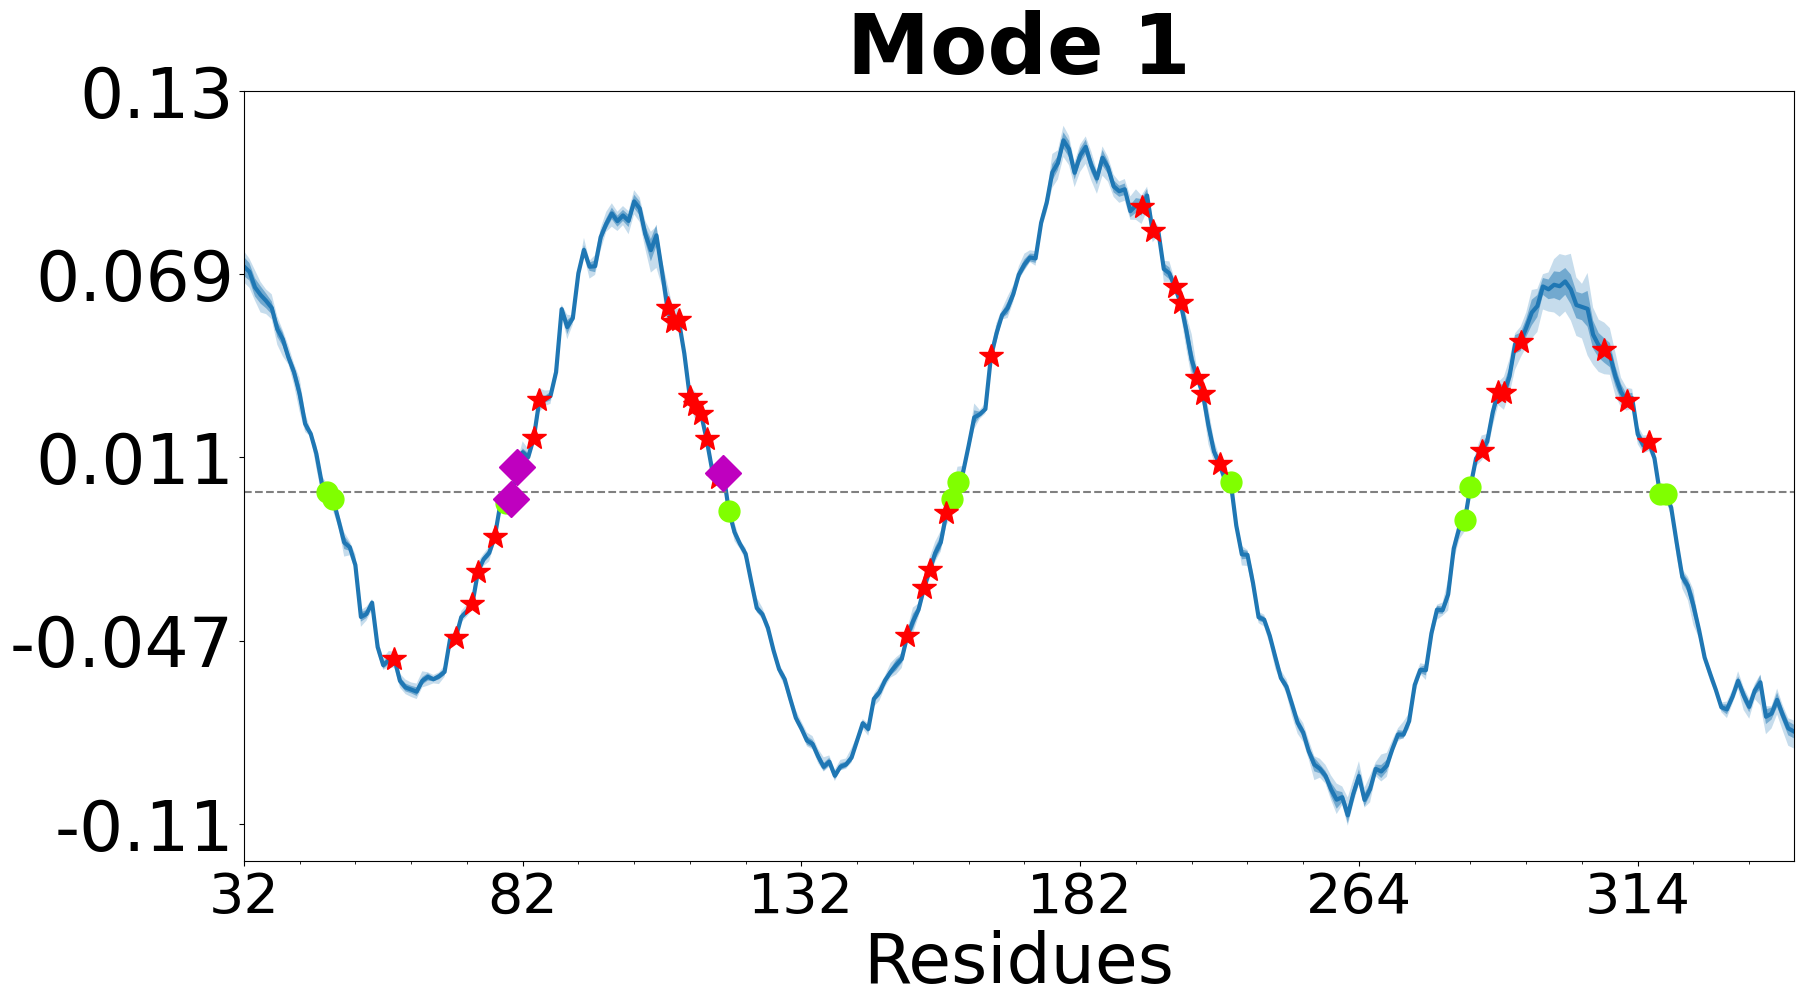

In [113]:
modes = 0 # Example modes
plotSingleGraph(modes, averageEigVecs, gnms, binding, [])

Hinge residue with wide bands [160, 161, 82, 83, 84, 85, 150, 151, 251, 252] 10
local loop motion []
current bindings are [27, 38, 41, 42, 45, 48, 49, 52, 53, 76, 77, 78, 80, 81, 82, 83, 85, 86, 119, 122, 123, 126, 134, 161, 163, 167, 168, 171, 172, 175, 222, 225, 226, 229, 244, 248, 252]
current hits are [82, 83, 85, 161, 252]
# of overlaps finding from current mode is 5


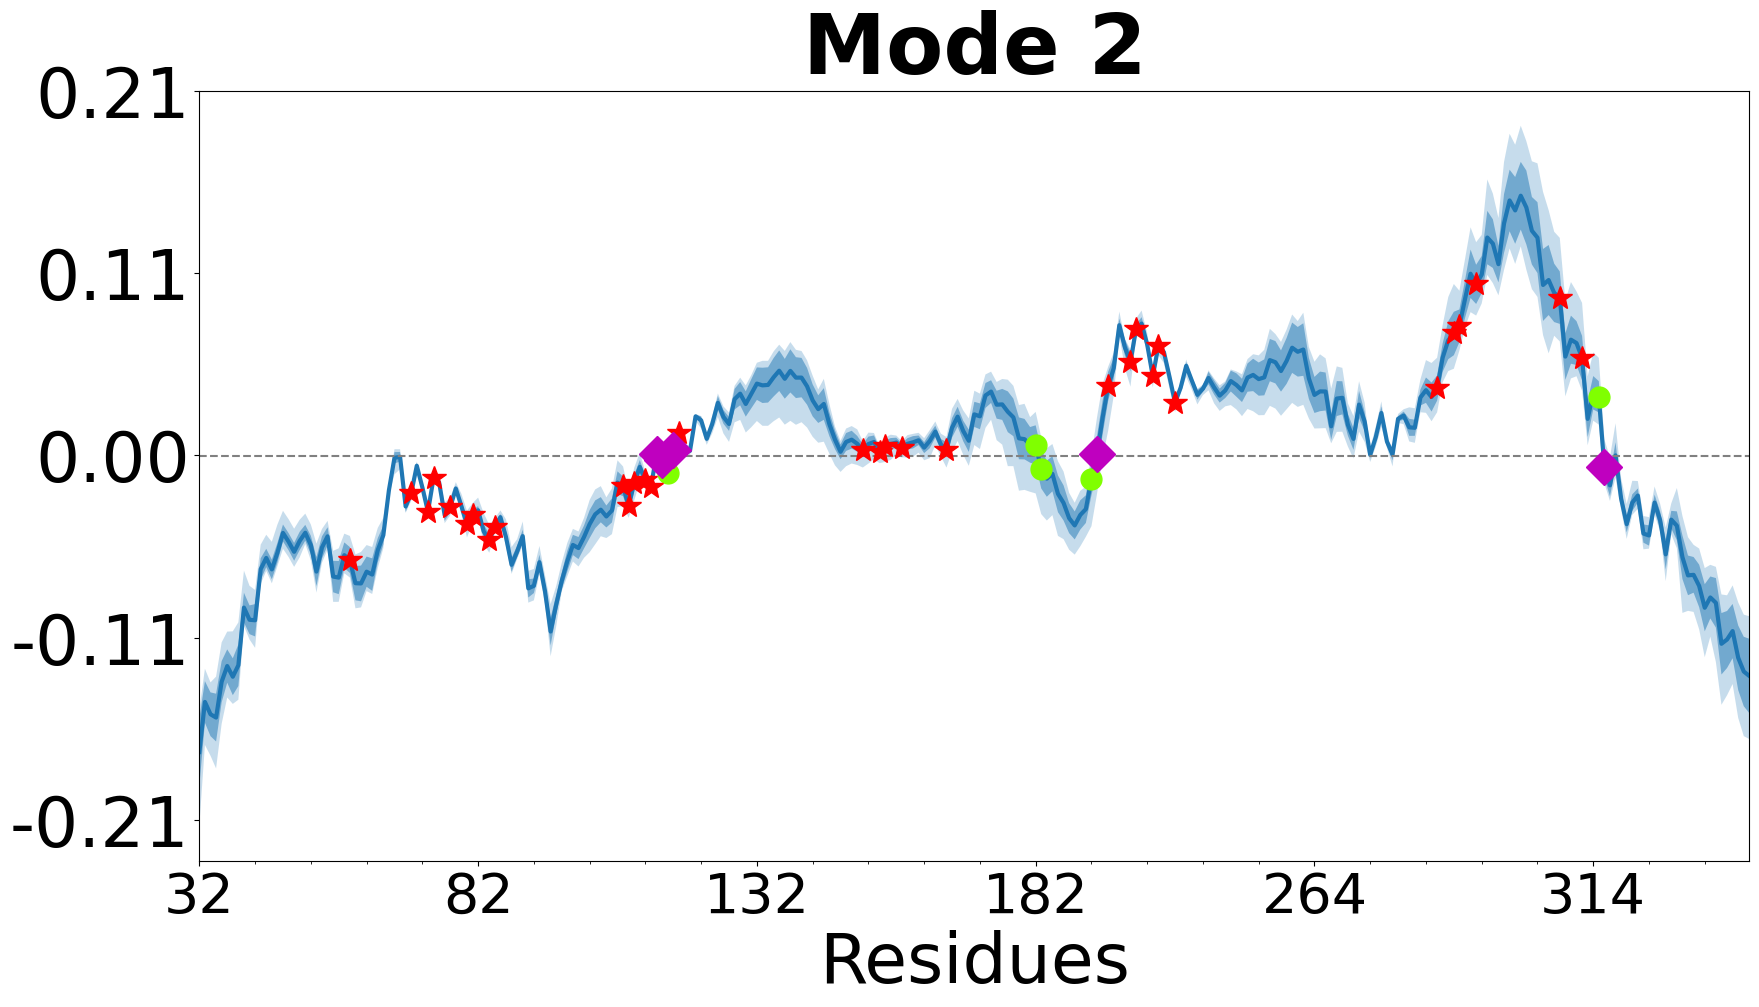

In [114]:
modes = 1 # Example modes
plotSingleGraph(modes, averageEigVecs, gnms, binding, [])

Hinge residue with wide bands [165, 166, 168, 167, 177, 178, 53, 54, 56, 57, 212, 213] 12
local loop motion []
current bindings are [27, 38, 41, 42, 45, 48, 49, 52, 53, 76, 77, 78, 80, 81, 82, 83, 85, 86, 119, 122, 123, 126, 134, 161, 163, 167, 168, 171, 172, 175, 222, 225, 226, 229, 244, 248, 252]
current hits are [53, 167, 168]
# of overlaps finding from current mode is 3


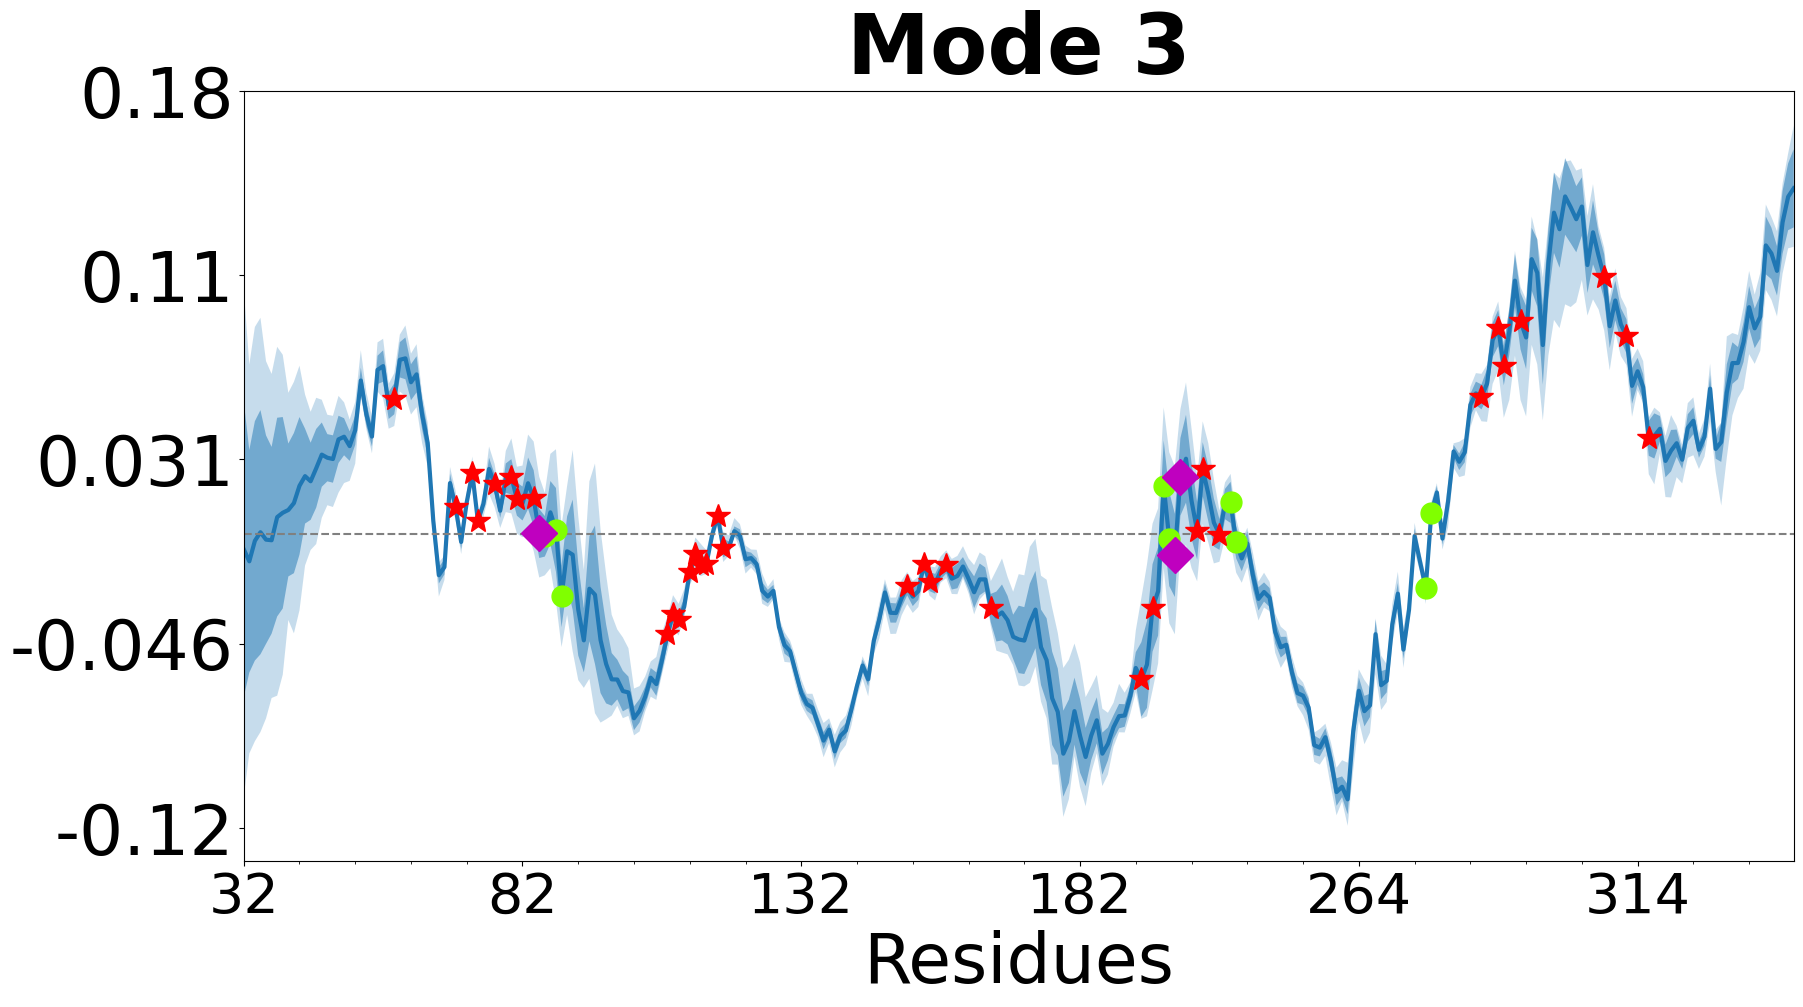

In [115]:
modes = 2 # Example modes
plotSingleGraph(modes, averageEigVecs, gnms, binding, [])